<a href="https://colab.research.google.com/github/seanreed1111/cnn-demos/blob/main/vae_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCB Skills Seminar: Building a VAE with PyTorch!

In this session, we will go over:
1. What is PyTorch?
2. Building an AutoEncoder
3. Extending the AutoEncoder to a Variational AutoEncoder

Before we start: 
1. Make a copy 
2. Make sure GPU runtime is selected. 
Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU

In [ ]:
# Imports
import torch
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

In [ ]:
# Download MNIST Dataset
torchvision.datasets.MNIST('./', download = True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [ ]:
# Option 2 in case Yann Lecun's website is down.

!pip install --upgrade --force-reinstall --quiet git+https://github.com/giuliano-oliveira/gdown@master
!gdown --folder https://drive.google.com/drive/folders/1EowAfwlIy2qwHHoJ-evAPmydrAiwNW9f?usp=sharing

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
Retrieving folder list
Retrieving folder 14-_-4E21vYEnegJL5T5XcQN-XmH709yQ processed
Processing file 17l6kwvUB0DbMZ6wvp3EW8YfpamKWDvrH test.pt
Processing file 1aXN-XoEhgDSZDgJeDAuhq5067Wjzg1_C training.pt
Retrieving folder 1qk14GKaZ0hESHJjWDeyvVjd-q_mtUuxI raw
Processing file 1-HnL46LvVXXWMhxEmqLTbLnnbcv2bcs_ t10k-images-idx3-ubyte
Processing file 14vXDASAa-uBElP9pJHQK_Jg2sudzfuDN t10k-images-idx3-ubyte.gz
Processing file 12kneVm2V0EHjaZYA8eKZzU1N4TihvdCr t10k-labels-idx1-ubyte
Processing file 140bSwrZjDoT-RMSEeRSGaJNaSOlqiXJ

## What is PyTorch?

It's a deep learning library that started at Facebook in 2016. Like TensorFlow, it offers neural network building blocks, autodifferentiation, GPU training, and much, much, more.

Initially it differentiated itself from TensorFlow 1.0 by offering eager execution (compared to TF's graph execution). TensorFlow 2.0 does now offer eager execution as well but PyTorch is definitely preferred in the research and startup ecosystem (as of March 2021). 

There's a great ecosystem surrounding PyTorch:
- [Visdom](https://github.com/fossasia/visdom) for visualization
- [PyTorchLightning](https://pytorchlightning.ai) for training
- [Pyro](https://pyro.ai) for deep probabilistic modeling
- [HuggingFace](https://huggingface.co/) for NLP
- [scvi-tools](https://https://scvi-tools.org/) for single cell data 

## Part 1: Building an AutoEncoder

Autoencoders are a type of **unsupervised** model. Meaning, we don't train on any labeled data (for tasks like clustering and dimensionality reduction). 

In contrast with **supervised** models which require labeled data (classification and regression tasks). 

Today, we will build a "vanilla" AutoEncoder for dimensionality reduction of the MNIST dataset.

Key terms:
- **Latent space**/**embedding**/**representation**: This it the lower dimensional representation of your data
- **Encoder**: The part of the model that maps your data to the latent space
- **Decoder**: The part of the model that tries to maps the latent space back to the original data.



Architecture of an AutoEncoder:

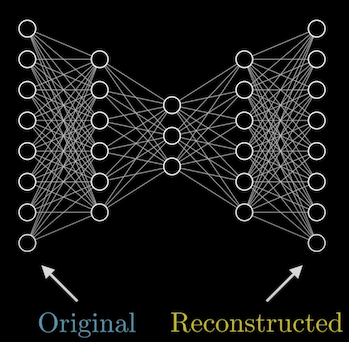

Source: https://youtu.be/3jmcHZq3A5s?t=117

### Let's first take a look at the data:

In [ ]:
images, ground_truth = torch.load('MNIST/processed/training.pt')

In [ ]:
print(images.shape) # we have 60k images of size 28x28
print(ground_truth.shape) # as expected we have an array of len 60k for ground truth


torch.Size([60000, 28, 28])
torch.Size([60000])


In [ ]:
# Our images between 0 and 255
print(torch.min(images[0]))
print(torch.max(images[0]))

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)


tensor(3)


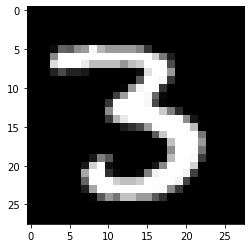

In [ ]:
image_index = 12

print(ground_truth[image_index]) # print the ground truth
plt.imshow(images[image_index], cmap='gray') # display the image

### Loading in the data

If you look at most PyTorch MNIST tutorials, there is already a easy data loader, but we're going to write our own. 

PyTorch has two types of Datasets:
- **MAP-style**: For data that is easy to access with an index (often as .h5 files)
- **iterable-style**: For data that you want to stream (video, text, etc)

In [ ]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    """
    Creates a MAP-style PyTorch Dataset. Can query the dataset via index. 
    
    Need to implement __getitem__ and __len__ methods. 
    """
    def __init__(self, path):
        # load the data into memory
        # generally speaking you don't want to do this
        self.images, self.ground_truth = torch.load(path)

    def __getitem__(self, idx):
        """
        Returns image with index idx.
        """
        x = self.images[idx].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) # "flatten" the image from (28x28) to (784)
        return x
    
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.ground_truth)

In [ ]:
# Lets make our datasets:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

print("Train dataset length: ", len(train_dataset))
print("Test dataset length: ", len(test_dataset))

Train dataset length:  60000
Test dataset length:  10000


In [ ]:
train_dataset[67].shape

torch.Size([784])

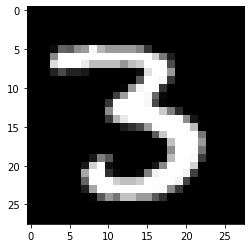

In [ ]:
plt.imshow(train_dataset[12].numpy().reshape((28,28)), cmap='gray')

### Finally, building our AutoEncoder
(Reminder: run training first)

Our network is going to have 4 fully connected layers. 2 for our encoder and then 2 for our decoder.

By having a bottleneck layer in the middle of the model, we're going to force the model to learn an "efficient" representation.

How do we train this? We can just minimize the mean squared error between the reconstructed data and the original data:

$MSE =  \frac{1}{N} \sum_{i=1}^{n}(X_i - \hat{X}_i)^2$

Recall the general architecture:

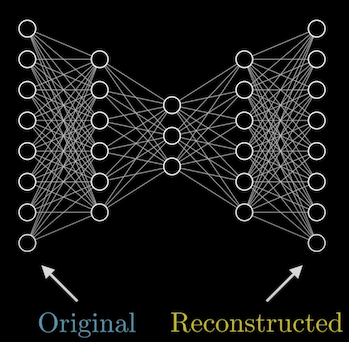



In [ ]:
import torch.nn as nn # submodule for neural network building blocks

class AutoEncoder(nn.Module):
    """
    AutoEncoder with fully connected layers.
    
    Architecture from: https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

    Parameters
    ----------
    input_shape
      shape of the input data
    latent_dim
      size of the latent dimension
    """
    def __init__(self, input_shape, latent_dim = 128):
      super().__init__()
      # two fully connected layers for encoder (input_shape -> latent_dim)
      self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
      self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
      
      # two fully connected layers for decoder (128 -> input_shape)
      self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
      self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
    

    def forward(self, x):
      """
      Define how your network is going to be run.

      Parameters
      ----------
      x
        Input data
      
      Returns
      -------
      x_hat 
        Reconstructed data

      """
      latent = self.run_encoder(x)
      x_hat = self.run_decoder(latent)
      return x_hat

    def run_encoder(self, x):
      # Runs encoder
      output = F.relu(self.encoder_l1(x)) # relu adds non linearity
      latent = F.relu(self.encoder_l2(output)) # this our latent representation
      return latent

    def run_decoder(self, latent):
      # Runs decoder
      output = F.relu(self.decoder_l1(latent))
      x_hat = F.relu(self.decoder_l2(output)) # reconstructed images
      return x_hat

### Training our model!

Here we define our loss, our optimizer, and the training loop. 

In [ ]:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

# get the shape of our input data
image_shape = train_dataset[0].shape[0]
print(image_shape)

# initialize AutoEncoder
model = AutoEncoder(input_shape = image_shape)

# move the model onto GPU
model.cuda()

784


AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

#### eval() vs train() mode

In PyTorch your model can be in two modes, eval() and train(). Certain layers perform differently in each mode (BatchNorm, Dropout). By default, the model is in train() mode but always good to set it. 

In [ ]:
# set our model to train()
model.train()

AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

#### Defining our loss, optimizer, and training loop

In [ ]:
# Training loop from: 
# https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

import torch.optim as optim

# make our training data loader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

# mean-squared error loss
mse = nn.MSELoss()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

for epoch in range(n_epochs):
    loss = 0

    # batch_features is each training batch
    # of shape (batch_size x n_features) 
    # in our case it's (128, 784)
    for batch_features in train_loader:
        # put data onto GPU
        batch_features = batch_features.cuda()

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = mse(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    if epoch %5 ==0:
      # display the epoch training loss every 5 epochs
      print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))


epoch : 1/100, loss = 1944.263679
epoch : 6/100, loss = 808.661680
epoch : 11/100, loss = 740.580057
epoch : 16/100, loss = 707.883699
epoch : 21/100, loss = 688.496495
epoch : 26/100, loss = 675.229158
epoch : 31/100, loss = 667.097391
epoch : 36/100, loss = 659.902391
epoch : 41/100, loss = 654.741953
epoch : 46/100, loss = 650.269185
epoch : 51/100, loss = 648.214876
epoch : 56/100, loss = 645.835822
epoch : 61/100, loss = 643.563623
epoch : 66/100, loss = 641.296914
epoch : 71/100, loss = 639.627305
epoch : 76/100, loss = 637.531457
epoch : 81/100, loss = 635.752661
epoch : 86/100, loss = 634.264587
epoch : 91/100, loss = 633.024320
epoch : 96/100, loss = 632.097674
epoch : 100/100, loss = 631.611018


### Evaluating our model

Let's visually see how well our model does at reconstructing the input image. Remember to put it into eval() mode!

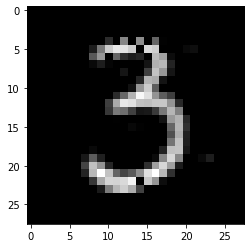

In [ ]:
# putting the model into eval() model
model.eval()

# visualizing the output of the train set
image_idx = 50

image = train_dataset[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray') # reconstructed image

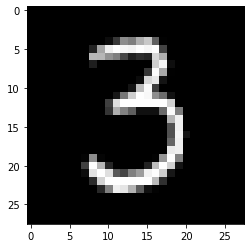

In [ ]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # original input image

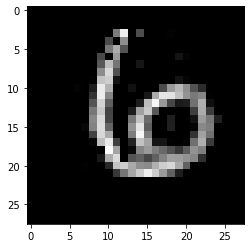

In [ ]:
# Visualizing test images
image_idx = 100

image = test_dataset[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray')

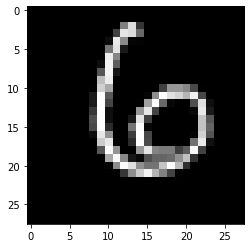

In [ ]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # ground truth test image

### Getting the latent representation
Now that the model is trained, we can just get the latent representation of our data which can then be fed to downstream tasks.

In [ ]:
# when you wrap a function with torch.no_grad() it doesnt compute the gradient
@torch.no_grad()
def get_latent_representation(model, dataloader):
  latent_representation = []
  for batch in dataloader:
    batch = batch.cuda()
    #run the encoder only
    latent = model.run_encoder(batch)
    latent = latent.cpu().numpy()
    latent_representation.append(latent)
  latent_representation = np.concatenate(latent_representation)
  return latent_representation

latent = get_latent_representation(model, train_loader)
latent.shape

# now you can build a classifier on top of the latent space
# or run unsupervised clustering, the possibilities are endless!

(60000, 128)

## Part 2: Extending to a Variational AutoEncoder
(reminder: train model first)

Okay, that was cool, but what if I want to "generate" images? What if we want to impose some constraints on the latent space?

In our AutoEncoder, we had no constraints on the latent space. Now, we're going to constrain our latent space to be drawn from a Normal distribution.

Instead of the encoder directly outputting the latent space, its going to output a vector of means and a vector of variances from which we will sample the latent space from. 

This gives us the following benefits:
1. You have constraints on the latent space, can specify priors on your latent variables
2. It's now a generative model


From the graphical models perspective, this is known as amortized variational inference.

General Architecture:

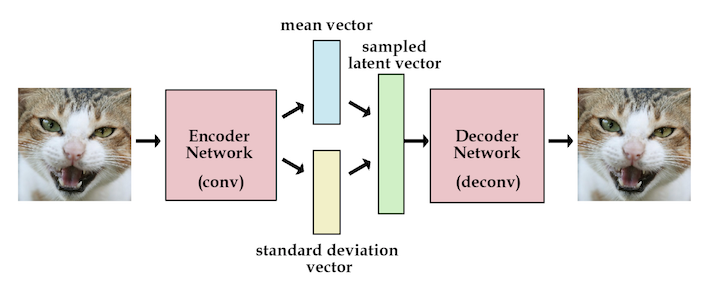

Source: http://kvfrans.com/variational-autoencoders-explained/

### VAE Loss function

We will slightly reformulate our problem. Now we are learning the parameters of a distribution. The encoder learns the parameters for q(z|x) and our decoder learns the parameters for p(x|z). In our case, we're going to assume that p(x|z) is Normal. p(x) is the prior distribution of our latent space, which in our case is going to be Normal.


In order to train our model, we will be maximizing the Evidence Lower BOund. This is motivated by the field of graphical models.

$ELBO = E_{q(z|x)}logp(x|z) - KL(q(z|x)||p(z))$

$ELBO = Reconstruction Loss - KL Divergence$

The first term is known as the reconstruction error. In our model, we are assuming that the data is normal, thus it is just MSE (same as our AutoEncoder!)

The second term is the KL divergence defined as:

$KL(q(x)||p(x)) = \int{p(x)log(\frac{p(x)}{q(x)})dx}$

This just measures how similar our latent distribution is to our prior distribution (unit Gaussian). 

In [ ]:
"""
All the following code in this section from:
https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/
by: Sovit Ranjan Rath

Go check it out!
"""

kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self,
                 image_channels = 1,
                 kernel_size = 4,
                 latent_dim = 16,
                 init_channels = 8):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        # Reparamaterization trick: instead of x ~ N(mu, std), 
        # do: x = mu + std * N(0,1) 
        # Now we can compute gradients w.r.t mu and std
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z) # this is our latent representation
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [ ]:
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{epoch}.jpg")

def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, dataset_size, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(dataset_size/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

### Training our VAE



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 50
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='./', train=True, download=False, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)

# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='./', train=False, download=False, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

In [ ]:
# we're using Adam optimizer here again
optimizer = optim.Adam(model.parameters(), lr=lr)

# Using Binary Cross Entropy loss for the 
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(
        model, trainloader, len(trainset), device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

  1%|          | 8/937 [00:00<00:12, 77.40it/s]

Epoch 1 of 50


938it [00:11, 79.54it/s]                         
157it [00:01, 123.08it/s]                         
  1%|          | 8/937 [00:00<00:11, 78.77it/s]

Train Loss: 14959.6366
Val Loss: 11414.4229
Epoch 2 of 50


938it [00:11, 79.44it/s]                         
157it [00:01, 126.12it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.98it/s]

Train Loss: 11110.6573
Val Loss: 10773.6751
Epoch 3 of 50


938it [00:11, 79.94it/s]                         
157it [00:01, 126.77it/s]                         
  1%|          | 8/937 [00:00<00:12, 76.45it/s]

Train Loss: 10761.7443
Val Loss: 10601.4088
Epoch 4 of 50


938it [00:11, 80.30it/s]                         
157it [00:01, 127.59it/s]                         
  1%|          | 8/937 [00:00<00:11, 79.61it/s]

Train Loss: 10582.9186
Val Loss: 10320.6716
Epoch 5 of 50


938it [00:11, 80.71it/s]                         
157it [00:01, 127.08it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.57it/s]

Train Loss: 10310.6039
Val Loss: 10198.2247
Epoch 6 of 50


938it [00:11, 80.80it/s]                         
157it [00:01, 121.08it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.44it/s]

Train Loss: 10198.4383
Val Loss: 10102.6936
Epoch 7 of 50


938it [00:11, 80.67it/s]                         
157it [00:01, 128.65it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.55it/s]

Train Loss: 10133.8970
Val Loss: 10061.4567
Epoch 8 of 50


938it [00:11, 81.46it/s]                         
157it [00:01, 128.62it/s]                         
  1%|          | 8/937 [00:00<00:12, 76.80it/s]

Train Loss: 10074.6114
Val Loss: 9943.5616
Epoch 9 of 50


938it [00:11, 80.44it/s]                         
157it [00:01, 128.59it/s]                         
  1%|          | 8/937 [00:00<00:11, 77.99it/s]

Train Loss: 9967.8694
Val Loss: 9915.2568
Epoch 10 of 50


938it [00:11, 81.57it/s]                         
157it [00:01, 130.84it/s]                         
  1%|          | 9/937 [00:00<00:11, 83.72it/s]

Train Loss: 9884.5108
Val Loss: 9786.0469
Epoch 11 of 50


938it [00:11, 81.91it/s]                         
157it [00:01, 120.64it/s]                         
  1%|          | 8/937 [00:00<00:12, 72.73it/s]

Train Loss: 9834.2873
Val Loss: 9779.5863
Epoch 12 of 50


938it [00:11, 81.67it/s]                         
157it [00:01, 129.58it/s]                         
  1%|          | 9/937 [00:00<00:11, 83.75it/s]

Train Loss: 9801.0570
Val Loss: 9801.5313
Epoch 13 of 50


938it [00:11, 82.09it/s]                         
157it [00:01, 130.16it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.72it/s]

Train Loss: 9778.1685
Val Loss: 9698.3565
Epoch 14 of 50


938it [00:11, 82.45it/s]                         
157it [00:01, 128.51it/s]                         
  1%|          | 9/937 [00:00<00:10, 86.37it/s]

Train Loss: 9750.0776
Val Loss: 9709.4640
Epoch 15 of 50


938it [00:11, 83.08it/s]                         
157it [00:01, 131.75it/s]                         
  1%|          | 9/937 [00:00<00:11, 80.63it/s]

Train Loss: 9733.3546
Val Loss: 9717.1395
Epoch 16 of 50


938it [00:11, 82.70it/s]                         
157it [00:01, 129.97it/s]                         
  1%|          | 9/937 [00:00<00:10, 84.67it/s]

Train Loss: 9716.3183
Val Loss: 9660.7633
Epoch 17 of 50


938it [00:11, 82.24it/s]                         
157it [00:01, 126.75it/s]                         
  1%|          | 8/937 [00:00<00:11, 77.92it/s]

Train Loss: 9699.5936
Val Loss: 9658.0814
Epoch 18 of 50


938it [00:11, 81.63it/s]                         
157it [00:01, 128.17it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.41it/s]

Train Loss: 9686.9894
Val Loss: 9656.2596
Epoch 19 of 50


938it [00:11, 82.48it/s]                         
157it [00:01, 129.44it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.08it/s]

Train Loss: 9677.2613
Val Loss: 9634.5149
Epoch 20 of 50


938it [00:11, 83.02it/s]                         
157it [00:01, 128.59it/s]                         
  1%|          | 9/937 [00:00<00:10, 86.47it/s]

Train Loss: 9662.4258
Val Loss: 9614.9134
Epoch 21 of 50


938it [00:11, 82.53it/s]                         
157it [00:01, 129.22it/s]                         
  1%|          | 9/937 [00:00<00:10, 85.70it/s]

Train Loss: 9652.0740
Val Loss: 9601.1427
Epoch 22 of 50


938it [00:11, 82.46it/s]                         
157it [00:01, 130.86it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.22it/s]

Train Loss: 9641.4485
Val Loss: 9605.6119
Epoch 23 of 50


938it [00:11, 82.76it/s]                         
157it [00:01, 131.33it/s]                         
  1%|          | 9/937 [00:00<00:10, 84.57it/s]

Train Loss: 9631.8462
Val Loss: 9592.5374
Epoch 24 of 50


938it [00:11, 83.16it/s]                         
157it [00:01, 129.38it/s]                         
  1%|          | 8/937 [00:00<00:11, 77.82it/s]

Train Loss: 9620.5488
Val Loss: 9583.2614
Epoch 25 of 50


938it [00:11, 82.93it/s]                         
157it [00:01, 132.76it/s]                         
  1%|          | 9/937 [00:00<00:11, 80.72it/s]

Train Loss: 9618.3188
Val Loss: 9580.2644
Epoch 26 of 50


938it [00:11, 82.32it/s]                         
157it [00:01, 133.67it/s]                         
  1%|          | 9/937 [00:00<00:10, 84.79it/s]

Train Loss: 9605.2946
Val Loss: 9590.1580
Epoch 27 of 50


938it [00:11, 82.14it/s]                         
157it [00:01, 131.85it/s]                         
  1%|          | 9/937 [00:00<00:11, 83.97it/s]

Train Loss: 9599.6572
Val Loss: 9568.0588
Epoch 28 of 50


938it [00:11, 83.30it/s]                         
157it [00:01, 132.04it/s]                         
  1%|          | 8/937 [00:00<00:11, 79.30it/s]

Train Loss: 9592.0473
Val Loss: 9584.6901
Epoch 29 of 50


938it [00:11, 83.81it/s]                         
157it [00:01, 132.91it/s]                         
  1%|          | 9/937 [00:00<00:11, 83.35it/s]

Train Loss: 9584.6124
Val Loss: 9562.4473
Epoch 30 of 50


938it [00:11, 82.31it/s]                         
157it [00:01, 131.51it/s]                         
  1%|          | 7/937 [00:00<00:14, 65.82it/s]

Train Loss: 9577.5439
Val Loss: 9562.0116
Epoch 31 of 50


938it [00:11, 82.55it/s]                         
157it [00:01, 131.29it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.22it/s]

Train Loss: 9573.0404
Val Loss: 9592.0850
Epoch 32 of 50


938it [00:11, 83.70it/s]                         
157it [00:01, 130.07it/s]                         
  1%|          | 8/937 [00:00<00:12, 77.26it/s]

Train Loss: 9567.8814
Val Loss: 9530.6995
Epoch 33 of 50


938it [00:11, 80.48it/s]                         
157it [00:01, 127.92it/s]                         
  1%|          | 9/937 [00:00<00:11, 84.33it/s]

Train Loss: 9564.2010
Val Loss: 9523.5506
Epoch 34 of 50


938it [00:11, 83.71it/s]                         
157it [00:01, 131.84it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.83it/s]

Train Loss: 9561.1611
Val Loss: 9528.9616
Epoch 35 of 50


938it [00:11, 82.72it/s]                         
157it [00:01, 132.93it/s]                         
  1%|          | 8/937 [00:00<00:11, 78.29it/s]

Train Loss: 9551.7681
Val Loss: 9531.5534
Epoch 36 of 50


938it [00:11, 83.43it/s]                         
157it [00:01, 133.63it/s]                         
  1%|          | 9/937 [00:00<00:10, 86.31it/s]

Train Loss: 9547.6175
Val Loss: 9541.7760
Epoch 37 of 50


938it [00:11, 83.14it/s]                         
157it [00:01, 131.55it/s]                         
  1%|          | 9/937 [00:00<00:11, 80.80it/s]

Train Loss: 9544.5194
Val Loss: 9549.7443
Epoch 38 of 50


938it [00:11, 83.22it/s]                         
157it [00:01, 131.78it/s]                         
  1%|          | 9/937 [00:00<00:10, 85.57it/s]

Train Loss: 9541.4982
Val Loss: 9521.1576
Epoch 39 of 50


938it [00:11, 83.54it/s]                         
157it [00:01, 127.72it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.99it/s]

Train Loss: 9538.0262
Val Loss: 9535.5537
Epoch 40 of 50


938it [00:11, 82.99it/s]                         
157it [00:01, 130.25it/s]                         
  1%|          | 8/937 [00:00<00:11, 77.65it/s]

Train Loss: 9533.0374
Val Loss: 9511.9968
Epoch 41 of 50


938it [00:11, 82.88it/s]                         
157it [00:01, 131.90it/s]                         
  1%|          | 8/937 [00:00<00:11, 79.80it/s]

Train Loss: 9531.0665
Val Loss: 9523.3913
Epoch 42 of 50


938it [00:11, 83.22it/s]                         
157it [00:01, 129.82it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.93it/s]

Train Loss: 9526.4263
Val Loss: 9535.7002
Epoch 43 of 50


938it [00:11, 82.94it/s]                         
157it [00:01, 130.00it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.99it/s]

Train Loss: 9520.7458
Val Loss: 9551.7085
Epoch 44 of 50


938it [00:11, 82.95it/s]                         
157it [00:01, 132.14it/s]                         
  1%|          | 9/937 [00:00<00:11, 84.34it/s]

Train Loss: 9516.5977
Val Loss: 9542.2816
Epoch 45 of 50


938it [00:11, 83.23it/s]                         
157it [00:01, 131.23it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.51it/s]

Train Loss: 9515.8351
Val Loss: 9517.3907
Epoch 46 of 50


938it [00:11, 83.75it/s]                         
157it [00:01, 128.67it/s]                         
  1%|          | 9/937 [00:00<00:11, 81.51it/s]

Train Loss: 9511.6395
Val Loss: 9541.7760
Epoch 47 of 50


938it [00:11, 83.31it/s]                         
157it [00:01, 132.79it/s]                         
  1%|          | 9/937 [00:00<00:11, 83.69it/s]

Train Loss: 9509.7107
Val Loss: 9518.3954
Epoch 48 of 50


938it [00:11, 83.58it/s]                         
157it [00:01, 128.85it/s]                         
  1%|          | 9/937 [00:00<00:11, 84.28it/s]

Train Loss: 9507.5850
Val Loss: 9493.2034
Epoch 49 of 50


938it [00:11, 82.52it/s]                         
157it [00:01, 132.48it/s]                         
  1%|          | 9/937 [00:00<00:11, 82.30it/s]

Train Loss: 9501.3661
Val Loss: 9481.1576
Epoch 50 of 50


938it [00:11, 82.75it/s]                         
157it [00:01, 130.12it/s]                         

Train Loss: 9501.3563
Val Loss: 9491.8272


##Extra 
That was fun but the training code and moving stuff to cuda is really unelegant code you might say. 

Checkout [PyTorchLightning](https://www.pytorchlightning.ai/)!

Let's you define a model in a specific way, so that it handles all the training code under the hood, but also makes it super easy to customize. HIGHLY recommend for prototyping models.

References and resources:
- Original VAE paper: https://arxiv.org/abs/1312.6114
- https://www.youtube.com/watch?v=uaaqyVS9-rM
- http://kvfrans.com/variational-autoencoders-explained/
- https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
- https://www.jeremyjordan.me/variational-autoencoders/

